## San Francisco Restaurant Health Scores and Violations

This dataset was pulled from Kaggle. The link to can be found [here](https://www.kaggle.com/san-francisco/sf-restaurant-scores-lives-standard).

We will try to see if pulling in Yelp information can help predict a restaurant's health scores.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats
import seaborn as sns

In [2]:
#this has duplicate entries (we'll create our df of non-dups later)
temp_df = pd.read_csv('restaurant-scores-lives-standard.csv')

In [3]:
temp_df = temp_df.drop(columns=['business_id', 'business_phone_number', 'business_city', 'business_state', 'business_location', 'business_address', 'Zip Codes'])
#let's drop any records with null target values
temp_df = temp_df.dropna(subset=['inspection_score']).reset_index()

In [4]:
temp_df.shape

(39514, 17)

In [5]:
temp_df.loc[temp_df['business_name'] == 'Parada 22']

,index,business_name,business_postal_code,business_latitude,business_longitude,inspection_id,inspection_date,inspection_score,inspection_type,violation_id,violation_description,risk_category,Neighborhoods,Police Districts,Supervisor Districts,Fire Prevention Districts,Analysis Neighborhoods
17,40,Parada 22,94117,37.769303,-122.451961,62051_20180514,2018-05-14T00:00:00.000,86.0,Routine - Unscheduled,62051_20180514_103154,Unclean or degraded floors walls or ceilings,Low Risk,9.0,5.0,11.0,15.0,3.0
664,1140,Parada 22,94117,37.769303,-122.451961,62051_20180514,2018-05-14T00:00:00.000,86.0,Routine - Unscheduled,62051_20180514_103133,Foods not protected from contamination,Moderate Risk,9.0,5.0,11.0,15.0,3.0
713,1224,Parada 22,94117,37.769303,-122.451961,62051_20180514,2018-05-14T00:00:00.000,86.0,Routine - Unscheduled,62051_20180514_103132,Improper thawing methods,Moderate Risk,9.0,5.0,11.0,15.0,3.0
1866,3010,Parada 22,94117,37.769303,-122.451961,62051_20180514,2018-05-14T00:00:00.000,86.0,Routine - Unscheduled,62051_20180514_103116,Inadequate food safety knowledge or lack of ce...,Moderate Risk,9.0,5.0,11.0,15.0,3.0
29390,40887,Parada 22,94117,37.769303,-122.451961,62051_20190509,2019-05-09T00:00:00.000,88.0,Routine - Unscheduled,62051_20190509_103154,Unclean or degraded floors walls or ceilings,Low Risk,9.0,5.0,11.0,15.0,3.0
30965,42869,Parada 22,94117,37.769303,-122.451961,62051_20190509,2019-05-09T00:00:00.000,88.0,Routine - Unscheduled,62051_20190509_103124,Inadequately cleaned or sanitized food contact...,Moderate Risk,9.0,5.0,11.0,15.0,3.0
32390,44707,Parada 22,94117,37.769303,-122.451961,62051_20190509,2019-05-09T00:00:00.000,88.0,Routine - Unscheduled,62051_20190509_103144,Unapproved or unmaintained equipment or utensils,Low Risk,9.0,5.0,11.0,15.0,3.0


Well, there are multiple entries for the same inspection. We really only want one, so let's make that happen.

But first, let's remove some records that don't make sense.

In [6]:
#drop rows where there is no violation description, but they still had points subtracted
drop_index = temp_df.loc[(temp_df.violation_description.isnull()) & (temp_df.inspection_score < 100)].index
temp_df.drop(drop_index, inplace=True)

In [7]:
temp_df.loc[temp_df.violation_description.isnull(), 'inspection_score'].mean()

100.0

In [8]:
#no violation description means there was no violation - that's why they got a 100!
temp_df['violation_description'].fillna('No violation', inplace=True)
#null risk category means there was no violation and no risk
temp_df.risk_category.fillna('No Violation', inplace=True)

Ok, time to create a new df without any duplicate entries.

In [9]:
#loop through all the inspection id's and create a df of only one instance
ins_ids = temp_df['inspection_id'].unique()

names = []
zip_codes = []
lat = []
long = []
ids = []
date = []
score = []
ins_type = []
viol_id = []
neighborhoods = []
pol_dist = []
sup_dist = []
fire_dist = []
analy_nei = []
num_violations = []

for id in ins_ids:
    #new df for our one restaurant
    restaurant = temp_df.loc[temp_df.inspection_id == id]
    #sometimes there are no data for the inspection id?
    if (len(restaurant) > 0):
        #grab the index of the first one
        index = restaurant.index[0]
        #start appending some values
        names.append(restaurant['business_name'][index])
        zip_codes.append(restaurant['business_postal_code'][index])
        lat.append(restaurant['business_latitude'][index])
        long.append(restaurant['business_longitude'][index])
        ids.append(restaurant['inspection_id'][index])
        date.append(restaurant['inspection_date'][index])
        score.append(restaurant['inspection_score'][index])
        ins_type.append(restaurant['inspection_type'][index])
        viol_id.append(restaurant['violation_id'][index])
        neighborhoods.append(restaurant['Neighborhoods'][index])
        pol_dist.append(restaurant['Police Districts'][index])
        sup_dist.append(restaurant['Supervisor Districts'][index])
        fire_dist.append(restaurant['Fire Prevention Districts'][index])
        analy_nei.append(restaurant['Analysis Neighborhoods'][index])
        #if the score is 100, then there were no violations. All the others are counted and appended
        if (restaurant['inspection_score'][index] == 100):
            num_violations.append(0)
        else:
            num_violations.append(len(restaurant))

In [10]:
#we have the unique entires in lists. now let's add them to our df
df = pd.DataFrame()

df['business_name'] = names
df['business_postal_code'] =  zip_codes
df['business_latitude'] =  lat
df['business_longitude'] = long
df['inspection_id'] = ids
df['inspection_date'] = date
df['inspection_score'] =  score
df['inspection_type'] =  ins_type
df['violation_id'] =  viol_id
df['Neighborhoods'] =  neighborhoods
df['Police Districts'] =  pol_dist
df['Supervisor Districts'] =  sup_dist
df['Fire Prevention Districts'] =  fire_dist
df['Analysis Neighborhoods'] =  analy_nei
df['num_violations'] =  num_violations

In [11]:
print(df.inspection_id.nunique())
print(len(df))

12020
12020


Let's create counts of our different risk categories. A new feature!

In [12]:
low_risk = []
medium_risk = []
high_risk = []
no_risk_violation = []

ins_ids = temp_df['inspection_id'].unique()

for id in ins_ids:
    #each restaurant and the unique category counts
    restaurant = temp_df.loc[temp_df.inspection_id == id]
    counts = restaurant['risk_category'].value_counts()
    
    try:
        low_risk.append(counts['Low Risk'])
    except:
        low_risk.append(0)
        
    try:
        medium_risk.append(counts['Moderate Risk'])
    except:
        medium_risk.append(0)
        
    try:
        high_risk.append(counts['High Risk'])
    except:
        high_risk.append(0)
        
    try:
        no_risk_violation.append(counts['No Violation'])
    except:
        no_risk_violation.append(0)

In [13]:
#add our counts lists into our new df
df['low_risk_count'] = low_risk
df['medium_risk_count'] = medium_risk
df['high_risk_count'] = high_risk
df['no_risk_count'] = no_risk_violation

We can also create some calendar entry information!

In [14]:
import calendar
df['inspection_date'] = pd.to_datetime(df['inspection_date'])


df['Year'] = df['inspection_date'].dt.year
df['Month'] = df['inspection_date'].dt.month
df['Date'] = df['inspection_date'].dt.day
df['Day'] = df['inspection_date'].apply(lambda x: calendar.day_name[x.weekday()])

### Pull in our yelp data and merge into our new dataframe

In [15]:
#load our yelp reviews dataset
yelp_df = pd.read_csv('yelp_business.csv')

In [16]:
yelp_df.rename(columns={'id' : 'yelp_id', 'rating' : 'yelp_rating'}, inplace=True)

In [17]:
yelp_df.dropna(how='all', inplace=True)

In [18]:
#make everything lower so the merge goes better
df.business_name = df.business_name.apply(lambda x: x.lower())

yelp_df.name = yelp_df.name.apply(lambda x: x.lower())

In [19]:
#convert our '$' values into a numeric measure
yelp_df.price = yelp_df.price.apply(lambda x: len(x) if type(x) != float else np.nan)
yelp_df.price.fillna(yelp_df.price.median(), inplace=True)

In [20]:
df = df.merge(yelp_df, how='left', left_on='business_name', right_on='name')

In [21]:
df.shape

(12767, 29)

Let's do some data cleaning and filling null values.

In [22]:
filling_nans = ['Neighborhoods', 'Police Districts', 'Supervisor Districts', 'Fire Prevention Districts', 'Analysis Neighborhoods']

for column in filling_nans:
    df[column].fillna(df[column].median(), inplace=True)

Let's see if we can find any missing values that have yelp information AND only have a few missing values.

In [23]:
df = df.drop(columns=['violation_id', 'business_latitude', 'business_longitude'])

Found a few that we can fill in.

In [24]:
for i in range(len(df.business_name)):
    if (df['business_name'][i] == 'ghirardelli chocolate'):
        df['business_postal_code'][i] = 94103

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [25]:
for i in range(len(df.business_name)):
    if (df['business_name'][i] == 'sunrise deli'):
        df['business_postal_code'][i] = 94122

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [26]:
null = df.isnull().sum() / len(df) * 100
null[null > 0]

business_postal_code     2.357641
name                    69.530822
yelp_id                 69.530822
yelp_rating             69.530822
price                   69.530822
review_rating           69.530822
review_sentiment        69.530822
dtype: float64

So, which ones are missing?

In [27]:
df.dropna(inplace=True)

In [28]:
df.shape

(3876, 26)

In [29]:
print('The earliest date was {}'.format(min(df['inspection_date'])))
print('The latest date was {}'.format(max(df['inspection_date'])))

The earliest date was 2016-08-02 00:00:00
The latest date was 2019-08-01 00:00:00


In [30]:
numeric_columns = df.select_dtypes(include=['float64'])
cat_cols = df.loc[:, ~df.columns.isin(numeric_columns)]
cat_cols = cat_cols.drop(columns=['inspection_date', 'business_name', 'name', 'yelp_id', 'inspection_id'])

What does the inspection score (our target) variable look like?

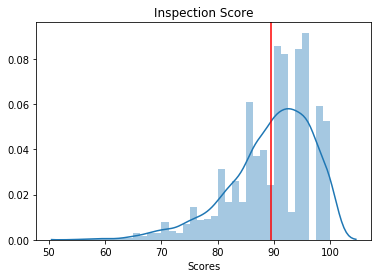

In [31]:
sns.distplot(df['inspection_score'])
plt.title('Inspection Score')
plt.xlabel('Scores')
plt.axvline(df['inspection_score'].mean(), color='red')
plt.show()

In [32]:
df['inspection_score'].describe()

count    3876.000000
mean       89.528122
std         7.427168
min        55.000000
25%        86.000000
50%        90.000000
75%        96.000000
max       100.000000
Name: inspection_score, dtype: float64

inspection_score
Correlation: 1.0 -- p_value: 0.0


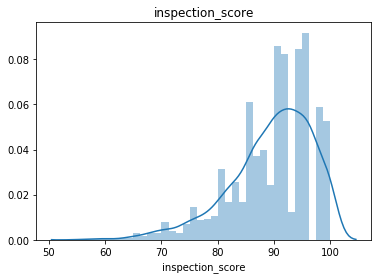

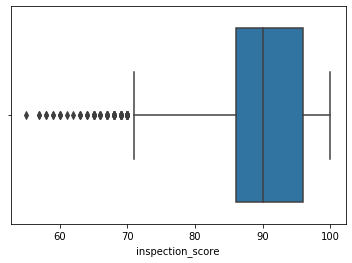

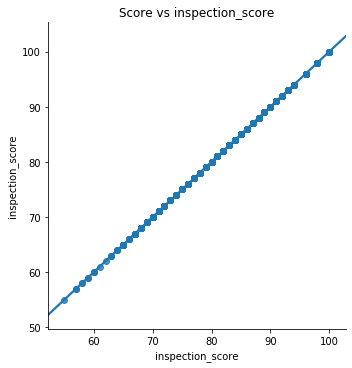


Neighborhoods
Correlation: 0.043661640225113194 -- p_value: 0.006554188727838461


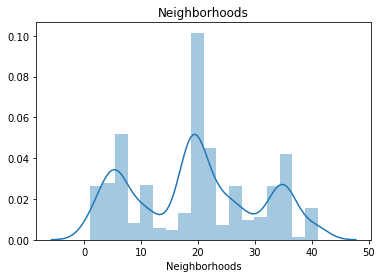

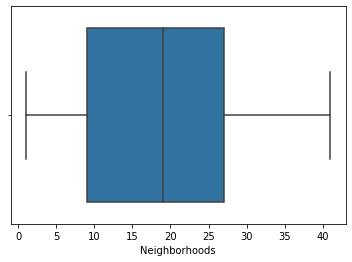

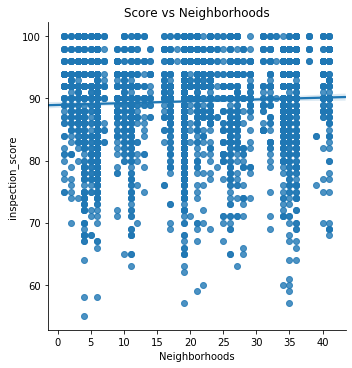


Police Districts
Correlation: -0.014810880893194628 -- p_value: 0.3566109962887313


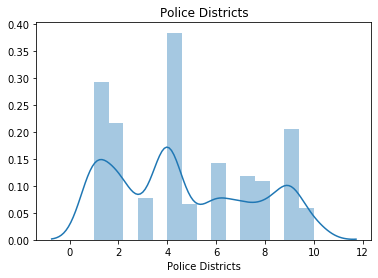

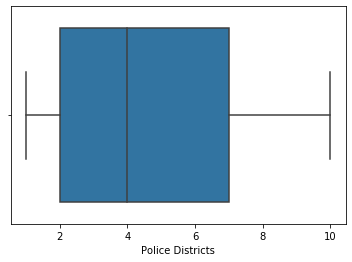

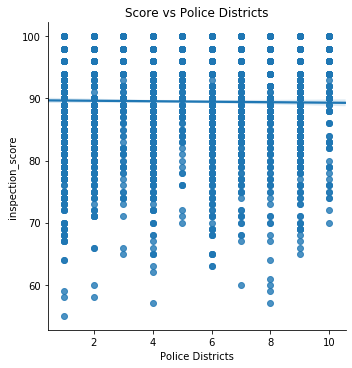


Supervisor Districts
Correlation: 0.04605084345441011 -- p_value: 0.004135872190958971


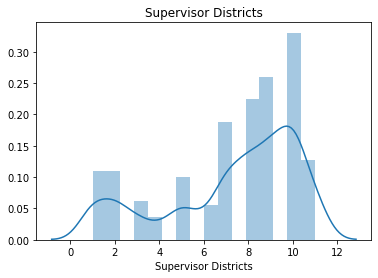

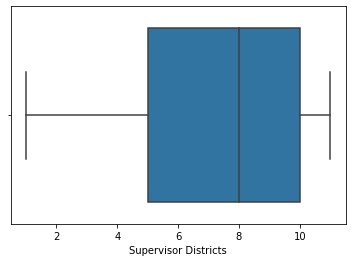

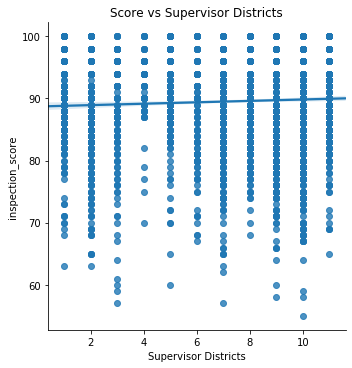


Fire Prevention Districts
Correlation: 0.026655976064865437 -- p_value: 0.09705641024270492


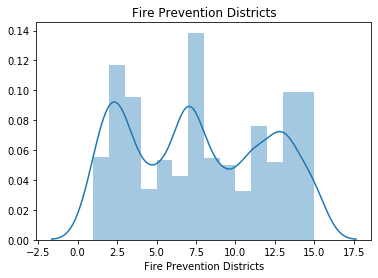

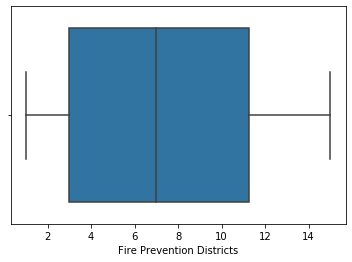

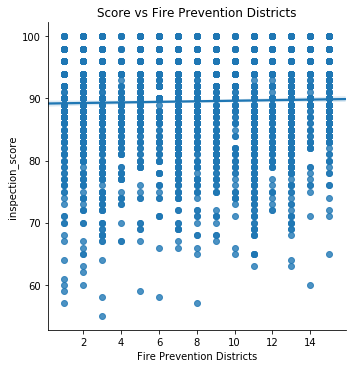


Analysis Neighborhoods
Correlation: 0.020241554966851205 -- p_value: 0.2077011771971872


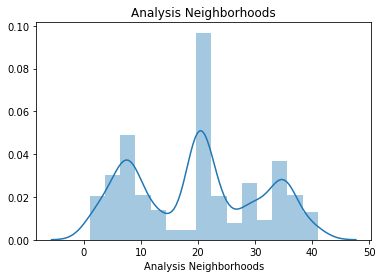

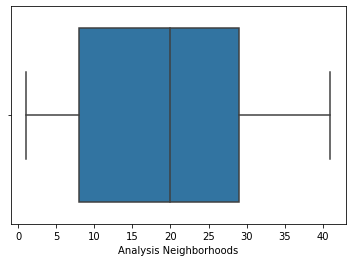

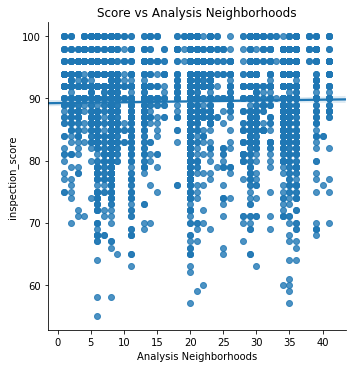


yelp_rating
Correlation: 0.10101164507753321 -- p_value: 2.9225364320570086e-10


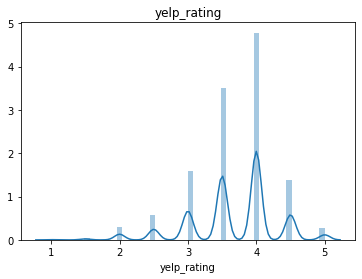

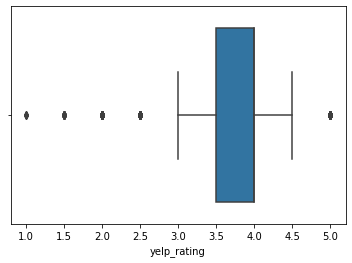

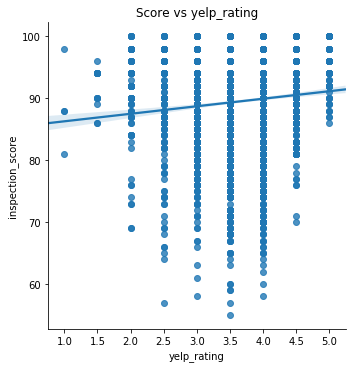


price
Correlation: 0.04618688697368842 -- p_value: 0.004026363708416817


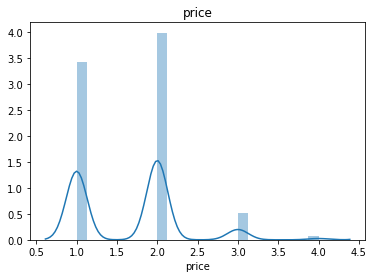

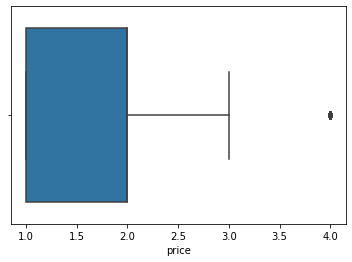

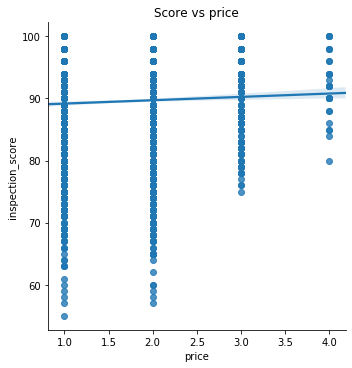


review_rating
Correlation: 0.07049774690388072 -- p_value: 1.1176303805349185e-05


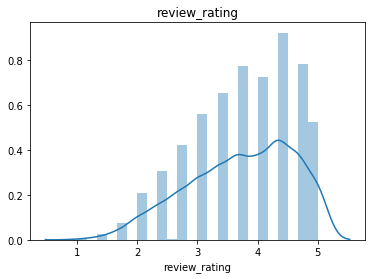

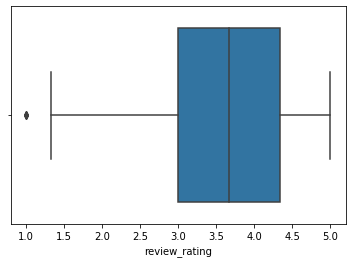

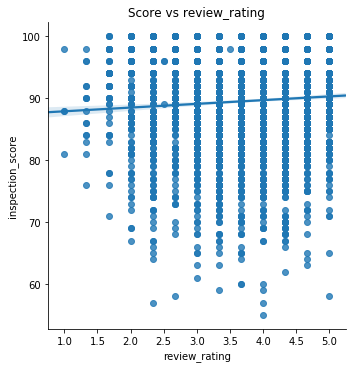


review_sentiment
Correlation: 0.08430155139460577 -- p_value: 1.4716507977900908e-07


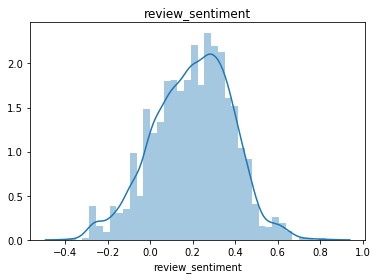

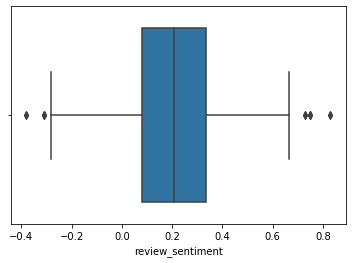

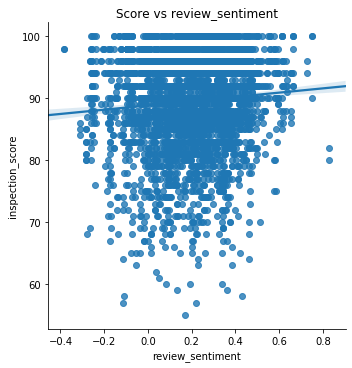

In [33]:
for column in numeric_columns:
    corr, p_value = stats.pearsonr(df[column], df.inspection_score)
    print('{}'.format(column))
    print('Correlation: {} -- p_value: {}'.format(corr, p_value))
    sns.distplot(df[column])
    plt.title('{}'.format(column))
    plt.show()
    
    sns.boxplot(df[column])
    plt.show()
    
    sns.lmplot(x=column, y='inspection_score', data=df)
    plt.title('Score vs {}'.format(column))
    plt.show()
    print('')

In [34]:
columns = numeric_columns.columns
r_squared = []
p_value = []
for column in numeric_columns:
    corr, p = stats.pearsonr(df[column], df.inspection_score)
    r_squared.append(abs(corr))
    p_value.append(p)
    
r_values = pd.DataFrame()
r_values['feature'] = columns
r_values['r_squared'] = r_squared
r_values['p_value'] = p_value

r_values = r_values.sort_values(by='r_squared', ascending=False).reset_index()
r_values[1:]

,index,feature,r_squared,p_value
1,6,yelp_rating,0.101012,2.922536e-10
2,9,review_sentiment,0.084302,1.471651e-07
3,8,review_rating,0.070498,1.117630e-05
4,7,price,0.046187,4.026364e-03
5,3,Supervisor Districts,0.046051,4.135872e-03
6,1,Neighborhoods,0.043662,6.554189e-03
7,4,Fire Prevention Districts,0.026656,9.705641e-02
8,5,Analysis Neighborhoods,0.020242,2.077012e-01
9,2,Police Districts,0.014811,3.566110e-01


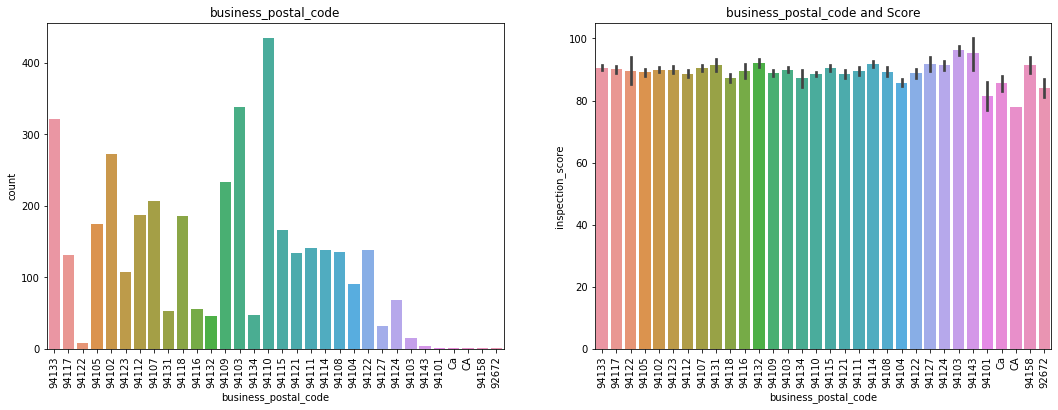

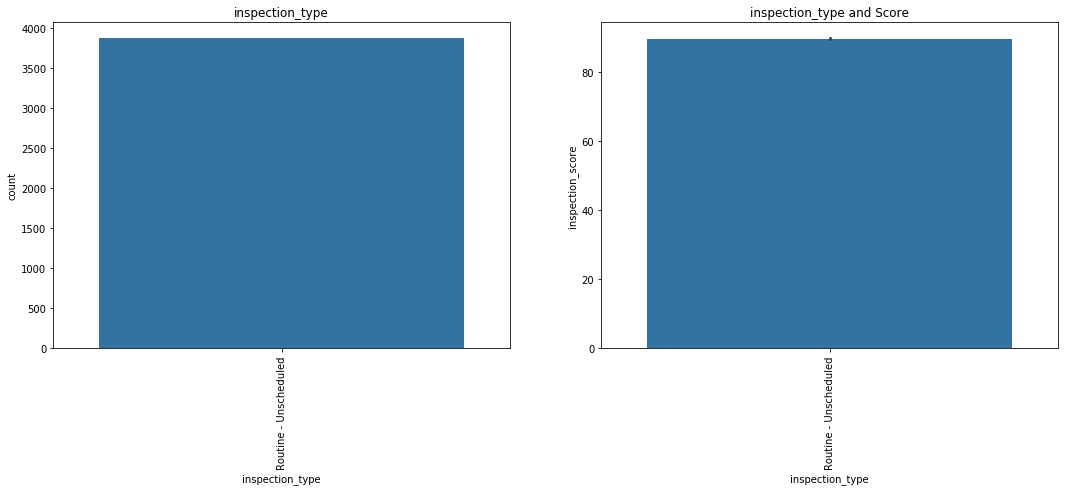

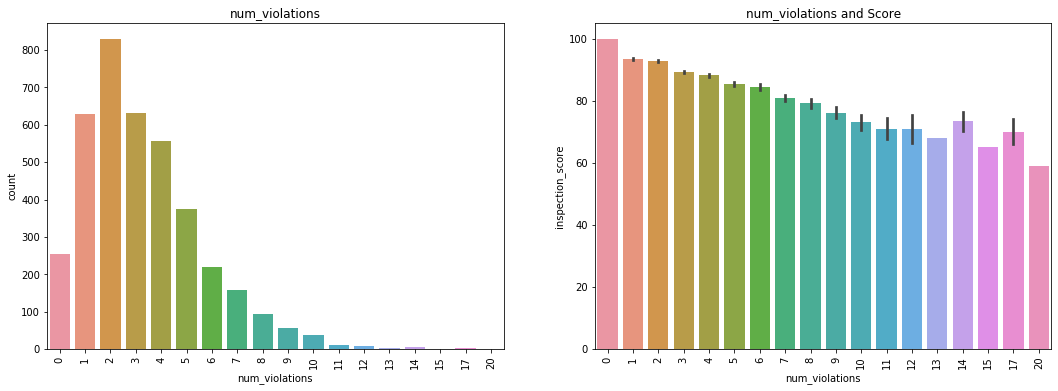

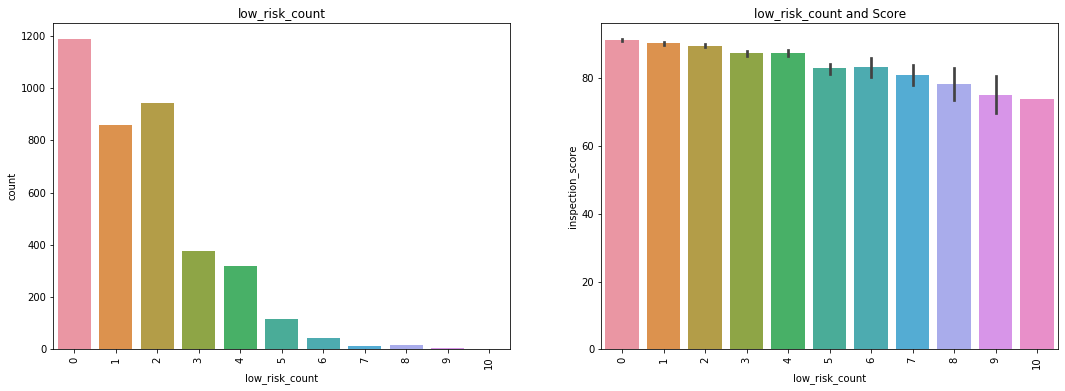

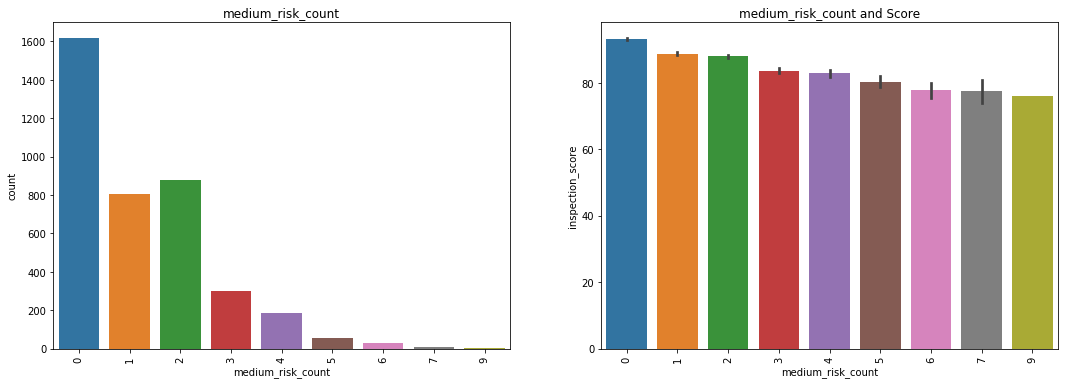

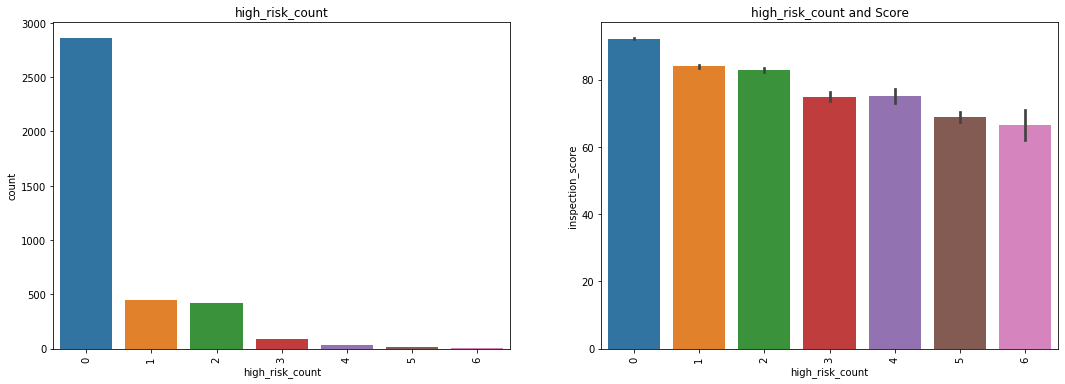

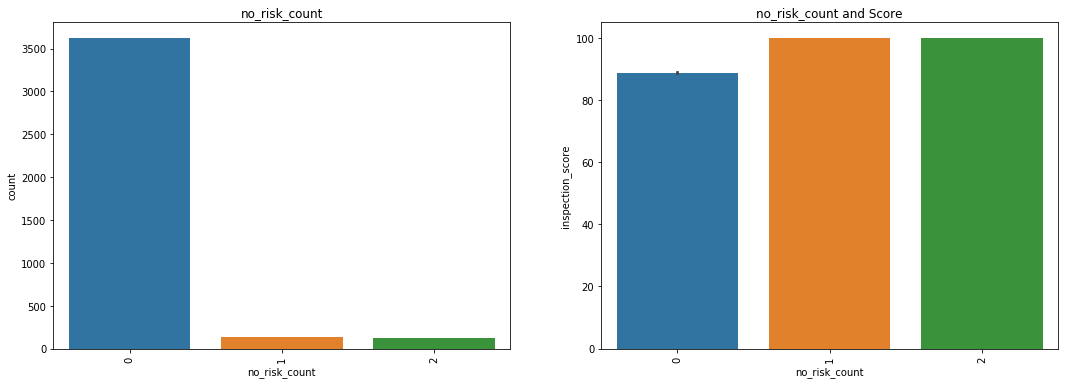

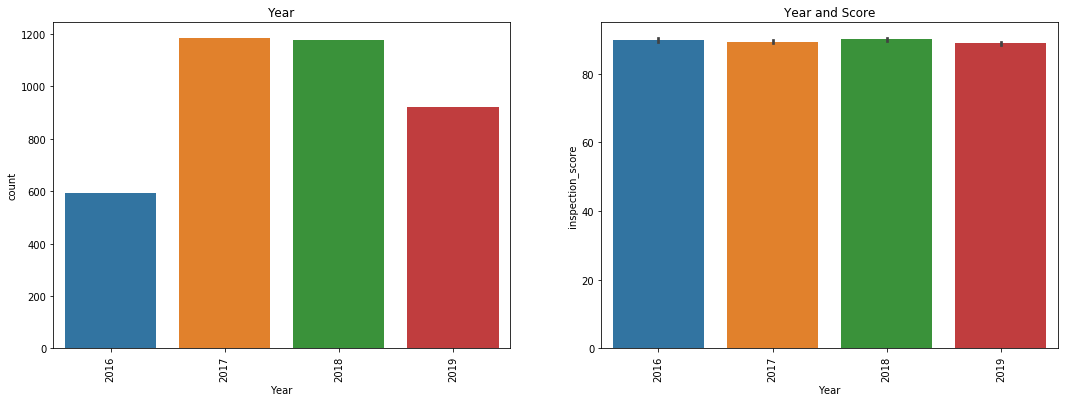

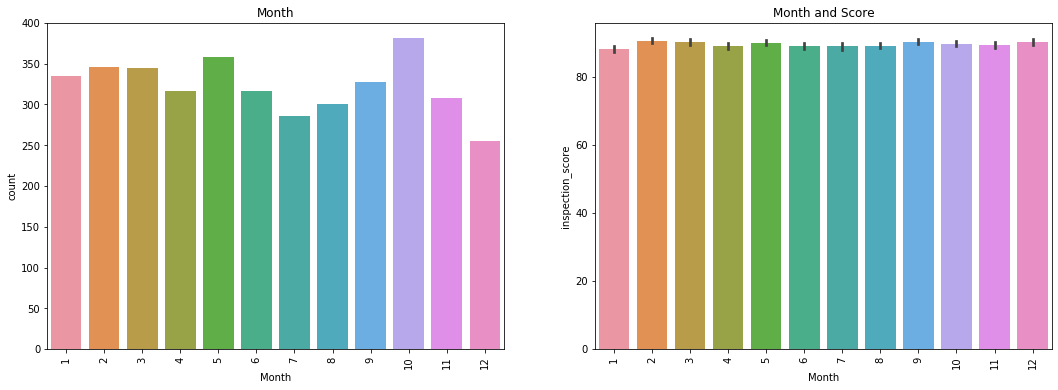

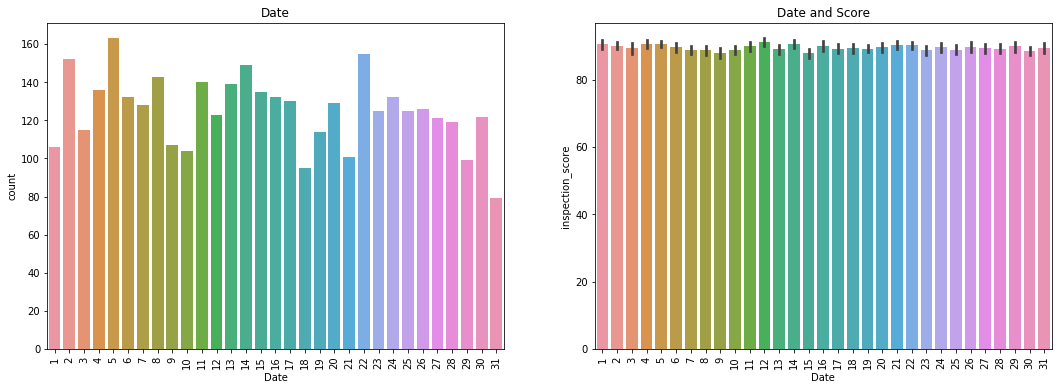

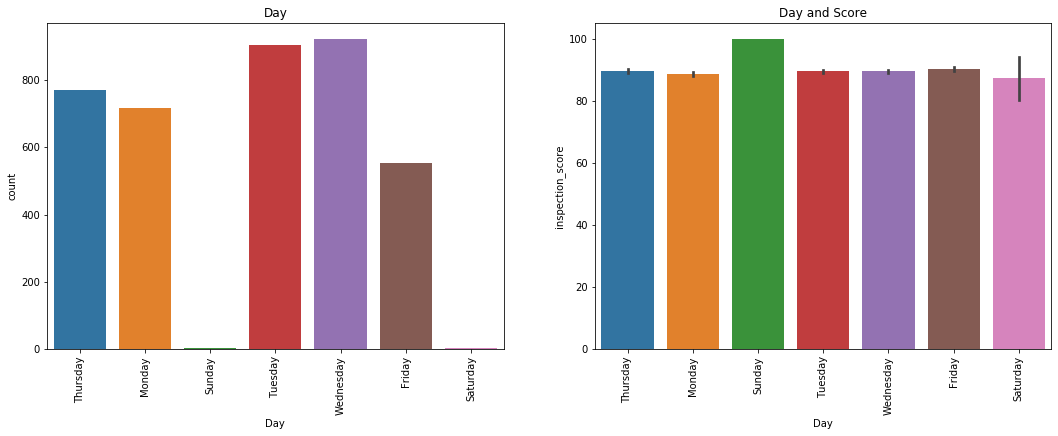

In [35]:
for column in cat_cols:
    plt.figure(figsize=(18, 6))
    
    plt.subplot(1, 2, 1)
    sns.countplot(df[column])
    plt.xticks(rotation='vertical')
    plt.title('{}'.format(column))
    
    plt.subplot(1, 2, 2)
    sns.barplot(x=column, y='inspection_score', data=df)
    plt.title('{} and Score'.format(column))
    plt.xticks(rotation='vertical')
    plt.show()

Ok, let's start getting our features and target ready for our models!

In [36]:
cat_features = ['num_violations', 'low_risk_count', 'medium_risk_count', 'high_risk_count', 'no_risk_count']

In [37]:
postal_code = pd.get_dummies(df['business_postal_code'], drop_first=True)
name = pd.get_dummies(df['business_name'], drop_first=True)
day = pd.get_dummies(df['Day'], drop_first=True)
year = pd.get_dummies(df['Year'], drop_first=True)
month = pd.get_dummies(df['Month'], drop_first=True)
date = pd.get_dummies(df['Date'], drop_first=True)

dummies_df = pd.concat([postal_code, name, day, year, month, date], axis=1)

In [38]:
X = pd.concat([numeric_columns, dummies_df], axis=1) 
X = X.drop(columns=['inspection_score'])
y = df['inspection_score']

### Random Forest Model

In [39]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [40]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=350, max_features='sqrt')
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=350,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [41]:
print('The r^2 of our test data is {}'.format(round(rfr.score(X_test, y_test), 4)))
print('The r^2 of our training data is {}'.format(round(rfr.score(X_train, y_train), 4)))

The r^2 of our test data is 0.4131
The r^2 of our training data is 0.9151


In [42]:
importance = rfr.feature_importances_
columns = X_train.columns

feature_df = pd.DataFrame()

feature_df['columns'] = columns
feature_df['importance'] = importance

feature_df.sort_values(by='importance', ascending=False).reset_index()[:10]

,index,columns,importance
0,8,review_sentiment,0.056959
1,5,yelp_rating,0.041488
2,7,review_rating,0.037737
3,0,Neighborhoods,0.028963
4,4,Analysis Neighborhoods,0.027912
5,3,Fire Prevention Districts,0.025053
6,934,starbucks,0.023129
7,2,Supervisor Districts,0.022994
8,1,Police Districts,0.020169
9,6,price,0.017922


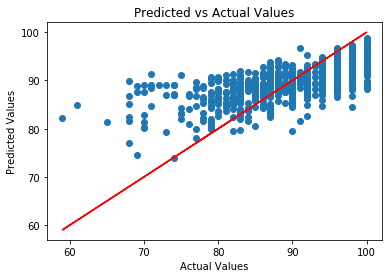

Root mean squared error of the prediction is: 5.485230210123896
Mean absolute percentage error of the prediction is: 4.72963723980524%


In [43]:
from statsmodels.tools.eval_measures import rmse

y_preds = rfr.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color='red')
plt.title('Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}%".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

### Scaled Data

This will help us with our nearest neighbor models and when do some dimensionality reduction.

In [44]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=10)

## KNN

__Uniform Distance__

In [45]:
from sklearn.neighbors import KNeighborsRegressor

knr = KNeighborsRegressor(n_neighbors=3)

knr.fit(X_train, y_train)
print('The r^2 of our test data is {}'.format(round(knr.score(X_test, y_test), 4)))
print('The r^2 of our training data is {}'.format(round(knr.score(X_train, y_train), 4)))

The r^2 of our test data is 0.1422
The r^2 of our training data is 0.6497


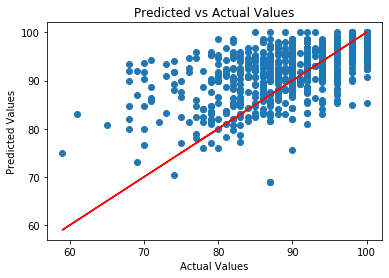

Root mean squared error of the prediction is: 6.631544078221714
Mean absolute percentage error of the prediction is: 5.601062578411482%


In [46]:
y_preds = knr.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color='red')
plt.title('Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}%".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

__Weighted Distance__

In [47]:
from sklearn.neighbors import KNeighborsRegressor

knr = KNeighborsRegressor(n_neighbors=9, weights='distance')

knr.fit(X_train, y_train)
print('The r^2 of our test data is {}'.format(round(knr.score(X_test, y_test), 4)))
print('The r^2 of our training data is {}'.format(round(knr.score(X_train, y_train), 4)))

The r^2 of our test data is 0.1573
The r^2 of our training data is 0.9998


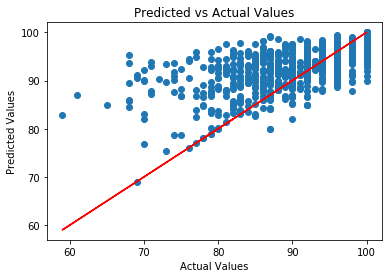

Root mean squared error of the prediction is: 6.572992005851321
Mean absolute percentage error of the prediction is: 5.45254562803099%


In [48]:
y_preds = knr.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color='red')
plt.title('Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}%".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

## Ridge Regression

In [49]:
from sklearn.linear_model import Ridge


ridgeregr = Ridge(alpha=10**3)
ridgeregr.fit(X_train, y_train)


print('The r^2 of our test data is {}'.format(round(ridgeregr.score(X_test, y_test), 4)))
print('The r^2 of our training data is {}'.format(round(ridgeregr.score(X_train, y_train), 4)))

The r^2 of our test data is 0.3608
The r^2 of our training data is 0.6809


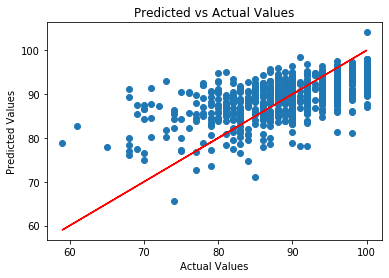

Root mean squared error of the prediction is: 5.724672847213518
Mean absolute percentage error of the prediction is: 5.117555166064471%


In [50]:
y_preds = ridgeregr.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color='red')
plt.title('Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}%".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

### SVM

In [51]:
from sklearn.svm import SVR

svr = SVR(kernel='rbf', C=7, epsilon=0.8, gamma='auto')
svr.fit(X_train, y_train)

print('The r^2 of our test data is {}'.format(round(svr.score(X_test, y_test), 4)))
print('The r^2 of our training data is {}'.format(round(svr.score(X_train, y_train), 4)))

The r^2 of our test data is 0.3663
The r^2 of our training data is 0.6546


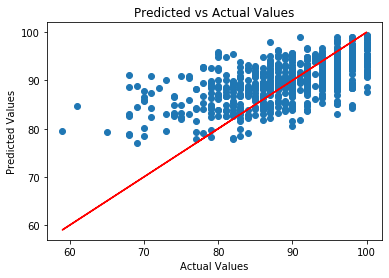

Root mean squared error of the prediction is: 5.699803011111964
Mean absolute percentage error of the prediction is: 4.959740329996248%


In [52]:
y_preds = svr.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color='red')
plt.title('Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}%".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

## Bagging Regressor

In [53]:
from sklearn.ensemble import BaggingRegressor
bgr = BaggingRegressor(max_features=1.0, max_samples=1.0, n_estimators=31)
bgr.fit(X_train, y_train)

BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=1.0, max_samples=1.0, n_estimators=31,
                 n_jobs=None, oob_score=False, random_state=None, verbose=0,
                 warm_start=False)

In [54]:
print('The r^2 of our test data is {}'.format(round(bgr.score(X_test, y_test), 4)))
print('The r^2 of our training data is {}'.format(round(bgr.score(X_train, y_train), 4)))

The r^2 of our test data is 0.3959
The r^2 of our training data is 0.9077


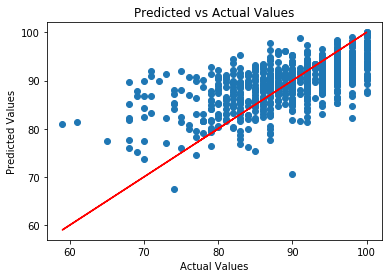

Root mean squared error of the prediction is: 5.565205639995187
Mean absolute percentage error of the prediction is: 4.726558632650332%


In [55]:
y_preds = bgr.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color='red')
plt.title('Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}%".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

### Gradient Boosting Regressor

In [56]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(learning_rate=1.0, n_estimators=101)

gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=1.0, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=101,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [57]:
print('The r^2 of our test data is {}'.format(round(gbr.score(X_test, y_test), 4)))
print('The r^2 of our training data is {}'.format(round(gbr.score(X_train, y_train), 4)))

The r^2 of our test data is 0.2305
The r^2 of our training data is 0.6971


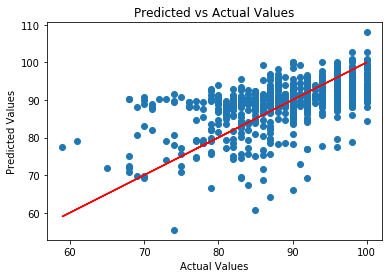

Root mean squared error of the prediction is: 6.281145010175083
Mean absolute percentage error of the prediction is: 5.370041972303945%


In [58]:
y_preds = gbr.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color='red')
plt.title('Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}%".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

### Adaboost Regression

In [59]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostRegressor
adr = AdaBoostRegressor(n_estimators=5 ,loss='linear')

adr.fit(X_train, y_train)
print('The r^2 of our test data is {}'.format(round(adr.score(X_test, y_test), 4)))
print('The r^2 of our training data is {}'.format(round(adr.score(X_train, y_train), 4)))

The r^2 of our test data is 0.0868
The r^2 of our training data is 0.0813


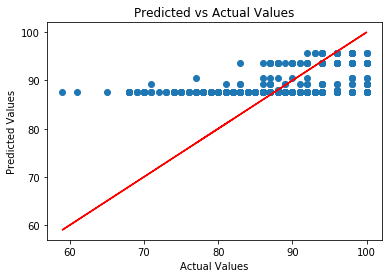

Root mean squared error of the prediction is: 6.842249239711857
Mean absolute percentage error of the prediction is: 6.248727458840447%


In [60]:
y_preds = adr.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color='red')
plt.title('Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}%".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

## PCA - Linear Regression and SVR

In [61]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
Xt = scaler.fit_transform(X)

pca = PCA()
pca.fit(Xt)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

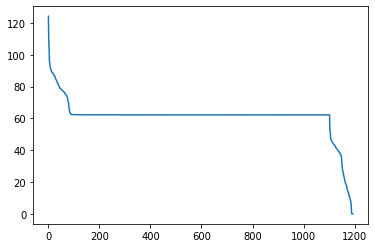

In [62]:
plt.plot(pca.singular_values_)
plt.show()

Tough to find a true 'elbow' so let's use the number of features needed to explain 50% of the features.

In [63]:
count = 0

for i in range(len(pca.explained_variance_ratio_)):
    count += pca.explained_variance_ratio_[i]
    if (count >= 0.5):
        print(i)

531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780


In [64]:
Xp = pca.transform(X)[:, 0:531]

In [65]:
y = df['inspection_score']

__LRM w/PCA__

In [66]:
X_train, X_test, y_train, y_test = train_test_split(Xp, y, test_size=0.2, random_state=10)

In [67]:
from sklearn.linear_model import LinearRegression

lrm = LinearRegression()
lrm.fit(X_train, y_train)

print('The r^2 of our test data is {}'.format(round(lrm.score(X_test, y_test), 4)))
print('The r^2 of our training data is {}'.format(round(lrm.score(X_train, y_train), 4)))

The r^2 of our test data is 0.2197
The r^2 of our training data is 0.4641


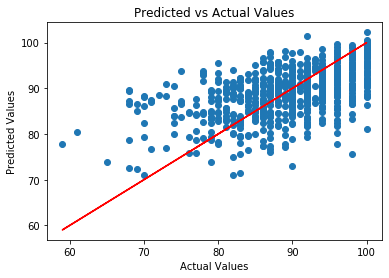

Root mean squared error of the prediction is: 6.324757343374702
Mean absolute percentage error of the prediction is: 5.6035365486771065%


In [68]:
y_preds = lrm.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color='red')
plt.title('Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}%".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

__SVR with PCA__

In [69]:
from sklearn.svm import SVR

parameters = {'kernel' : ('rbf', 'linear'), 'C' : np.arange(1, 12, 2), 'epsilon' : np.arange(0.1, 1.2, 0.2)}

svr = SVR(gamma='auto', kernel='linear', C=5, epsilon=1.1)
svr.fit(X_train, y_train)

print('The r^2 of our test data is {}'.format(round(svr.score(X_test, y_test), 4)))
print('The r^2 of our training data is {}'.format(round(svr.score(X_train, y_train), 4)))

The r^2 of our test data is 0.253
The r^2 of our training data is 0.3974


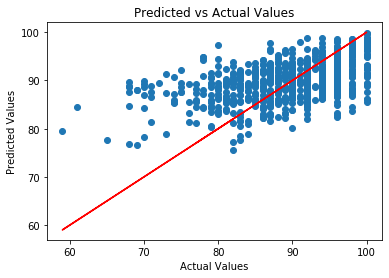

Root mean squared error of the prediction is: 6.188608466546513
Mean absolute percentage error of the prediction is: 5.454657007498192%


In [70]:
y_preds = svr.predict(X_test)


plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color='red')
plt.title('Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()


print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}%".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

## Let's try our top 2 models without names

In [71]:
cat_features = ['num_violations', 'low_risk_count', 'medium_risk_count', 'high_risk_count', 'no_risk_count']

In [72]:
postal_code = pd.get_dummies(df['business_postal_code'], drop_first=True)
name = pd.get_dummies(df['business_name'], drop_first=True)
day = pd.get_dummies(df['Day'], drop_first=True)
year = pd.get_dummies(df['Year'], drop_first=True)
month = pd.get_dummies(df['Month'], drop_first=True)
date = pd.get_dummies(df['Date'], drop_first=True)

dummies_df = pd.concat([postal_code, day, year, month, date], axis=1)

In [73]:
X = pd.concat([numeric_columns, dummies_df], axis=1) 
X = X.drop(columns=['inspection_score'])
y = df['inspection_score']

### Random Forest Regression

In [74]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=350, max_features='sqrt')
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=350,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [75]:
print('The r^2 of our test data is {}'.format(round(rfr.score(X_test, y_test), 4)))
print('The r^2 of our training data is {}'.format(round(rfr.score(X_train, y_train), 4)))

The r^2 of our test data is 0.4671
The r^2 of our training data is 0.9232


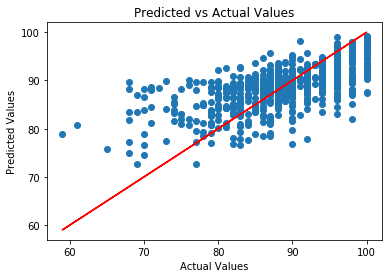

Root mean squared error of the prediction is: 5.227076118315375
Mean absolute percentage error of the prediction is: 4.448023155693542%


In [76]:
from statsmodels.tools.eval_measures import rmse

y_preds = rfr.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color='red')
plt.title('Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}%".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

### Bagging Regressor

In [77]:
bgr = BaggingRegressor(max_features=0.6, max_samples=1.0, n_estimators=101)
bgr.fit(X_train, y_train)

BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=0.6, max_samples=1.0, n_estimators=101,
                 n_jobs=None, oob_score=False, random_state=None, verbose=0,
                 warm_start=False)

In [78]:
print('The r^2 of our test data is {}'.format(round(bgr.score(X_test, y_test), 4)))
print('The r^2 of our training data is {}'.format(round(bgr.score(X_train, y_train), 4)))

The r^2 of our test data is 0.4622
The r^2 of our training data is 0.9207


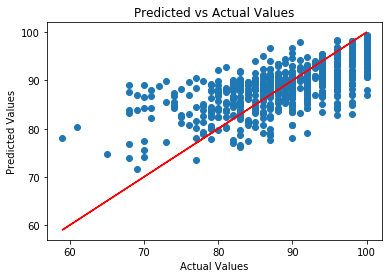

Root mean squared error of the prediction is: 5.250765075216511
Mean absolute percentage error of the prediction is: 4.47797384100022%


In [79]:
y_preds = bgr.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color='red')
plt.title('Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}%".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

## Now let's try, but add the violations

In [80]:
cat_features = ['num_violations', 'low_risk_count', 'medium_risk_count', 'high_risk_count', 'no_risk_count']

In [81]:
postal_code = pd.get_dummies(df['business_postal_code'], drop_first=True)
name = pd.get_dummies(df['business_name'], drop_first=True)
day = pd.get_dummies(df['Day'], drop_first=True)
year = pd.get_dummies(df['Year'], drop_first=True)
month = pd.get_dummies(df['Month'], drop_first=True)
date = pd.get_dummies(df['Date'], drop_first=True)

dummies_df = pd.concat([postal_code, name, day, year, month, date, df[cat_features]], axis=1)

In [82]:
X = pd.concat([numeric_columns, dummies_df], axis=1) 
X = X.drop(columns=['inspection_score'])
y = df['inspection_score']

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

### Random Forest Regression

In [84]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(max_features='sqrt', n_estimators=95)
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=95,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [85]:
print('The r^2 of our test data is {}'.format(round(rfr.score(X_test, y_test), 4)))
print('The r^2 of our training data is {}'.format(round(rfr.score(X_train, y_train), 4)))

The r^2 of our test data is 0.7086
The r^2 of our training data is 0.959


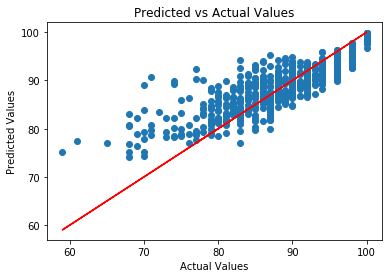

Root mean squared error of the prediction is: 3.8651901419561168
Mean absolute percentage error of the prediction is: 3.257214241135812%


In [86]:
from statsmodels.tools.eval_measures import rmse

y_preds = rfr.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color='red')
plt.title('Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}%".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

### Bagging Regressor

In [87]:
bgr = BaggingRegressor(max_features=0.6, max_samples=1.0, n_estimators=81)
bgr.fit(X_train, y_train)

BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=0.6, max_samples=1.0, n_estimators=81,
                 n_jobs=None, oob_score=False, random_state=None, verbose=0,
                 warm_start=False)

In [88]:
print('The r^2 of our test data is {}'.format(round(bgr.score(X_test, y_test), 4)))
print('The r^2 of our training data is {}'.format(round(bgr.score(X_train, y_train), 4)))

The r^2 of our test data is 0.741
The r^2 of our training data is 0.9641


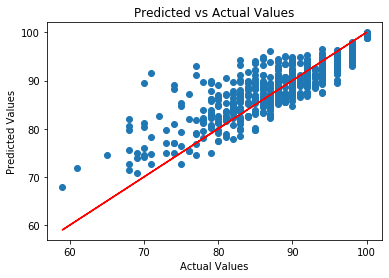

Root mean squared error of the prediction is: 3.644197296514671
Mean absolute percentage error of the prediction is: 3.0534464594030357%


In [89]:
y_preds = bgr.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color='red')
plt.title('Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}%".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

## Let's try our top 2 models without names, postal codes, and calendars

In [90]:
cat_features = ['num_violations', 'low_risk_count', 'medium_risk_count', 'high_risk_count', 'no_risk_count']

In [91]:
postal_code = pd.get_dummies(df['business_postal_code'], drop_first=True)
name = pd.get_dummies(df['business_name'], drop_first=True)
day = pd.get_dummies(df['Day'], drop_first=True)
year = pd.get_dummies(df['Year'], drop_first=True)
month = pd.get_dummies(df['Month'], drop_first=True)
date = pd.get_dummies(df['Date'], drop_first=True)

dummies_df = pd.concat([day], axis=1)

In [92]:
X = pd.concat([numeric_columns, dummies_df], axis=1) 
X = X.drop(columns=['inspection_score', 'Analysis Neighborhoods'])
y = df['inspection_score']

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

### Random Forest Regression

In [94]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=350, max_features='sqrt')
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=350,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [95]:
print('The r^2 of our test data is {}'.format(round(rfr.score(X_test, y_test), 4)))
print('The r^2 of our training data is {}'.format(round(rfr.score(X_train, y_train), 4)))

The r^2 of our test data is 0.2676
The r^2 of our training data is 0.8397


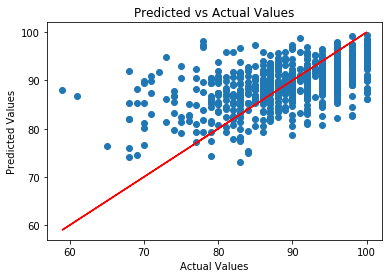

Root mean squared error of the prediction is: 6.127585185081337
Mean absolute percentage error of the prediction is: 5.338063911925365%


In [96]:
from statsmodels.tools.eval_measures import rmse

y_preds = rfr.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color='red')
plt.title('Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}%".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

### Bagging Regressor

In [97]:
bgr = BaggingRegressor(max_features=0.6, max_samples=1.0, n_estimators=101)
bgr.fit(X_train, y_train)

BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=0.6, max_samples=1.0, n_estimators=101,
                 n_jobs=None, oob_score=False, random_state=None, verbose=0,
                 warm_start=False)

In [98]:
print('The r^2 of our test data is {}'.format(round(bgr.score(X_test, y_test), 4)))
print('The r^2 of our training data is {}'.format(round(bgr.score(X_train, y_train), 4)))

The r^2 of our test data is 0.3284
The r^2 of our training data is 0.7537


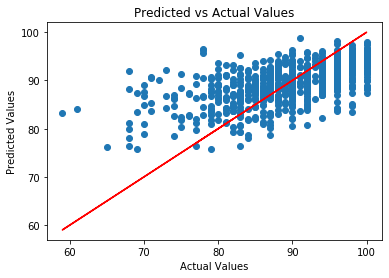

Root mean squared error of the prediction is: 5.867829556925064
Mean absolute percentage error of the prediction is: 5.196523166964655%


In [99]:
y_preds = bgr.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color='red')
plt.title('Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}%".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))